## Download data from kaggle

In [198]:
!pip install kaggle

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [199]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle (1).json


{'kaggle.json': b'{"username":"cum65705","key":"66ba2544006a3d7d2f2e681e347b346c"}'}

In [200]:
!ls -al
!mkdir -p ~/.kaggle
!ls -al ~/

total 48
drwxr-xr-x 1 root root  4096 Dec 17 15:12  .
drwxr-xr-x 1 root root  4096 Dec 17 13:04  ..
drwxr-xr-x 4 root root  4096 Dec 16 00:00  .config
-rw-r--r-- 1 root root    64 Dec 17 15:12 'kaggle (1).json'
-rw-r--r-- 1 root root    64 Dec 17 13:05  kaggle.json
drwxr-xr-x 1 root root  4096 Dec 16 00:01  sample_data
-rw-r--r-- 1 root root 15021 Sep 29  2019 'Wholesale customers data.csv'
-rw-r--r-- 1 root root  7017 Dec 17 13:05  wholesale-customers-data-set.zip
total 64
drwx------ 1 root root 4096 Dec 17 13:05 .
drwxr-xr-x 1 root root 4096 Dec 17 13:04 ..
-r-xr-xr-x 1 root root 1169 Jan  1  2000 .bashrc
drwxr-xr-x 1 root root 4096 Dec 16 00:16 .cache
drwx------ 4 root root 4096 Dec 16 00:15 .config
drwxr-xr-x 5 root root 4096 Dec 16 00:15 .ipython
drwx------ 2 root root 4096 Dec 16 00:15 .jupyter
drwxr-xr-x 2 root root 4096 Dec 17 13:05 .kaggle
drwxr-xr-x 2 root root 4096 Dec 16 00:12 .keras
drwxr-xr-x 1 root root 4096 Dec 16 00:15 .local
drwxr-xr-x 4 root root 4096 Dec 16 00:15 .n

In [201]:
!cp kaggle.json ~/.kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!ls -al ~/.kaggle/

total 16
drwxr-xr-x 2 root root 4096 Dec 17 13:05 .
drwx------ 1 root root 4096 Dec 17 13:05 ..
-rw------- 1 root root   64 Dec 17 15:12 kaggle.json


In [202]:
!kaggle datasets download -d binovi/wholesale-customers-data-set

wholesale-customers-data-set.zip: Skipping, found more recently modified local copy (use --force to force download)


In [203]:
!unzip wholesale-customers-data-set.zip

Archive:  wholesale-customers-data-set.zip
replace Wholesale customers data.csv? [y]es, [n]o, [A]ll, [N]one, [r]ename: n


## Load library

In [436]:
# data
import pandas as pd
import numpy as np
import warnings
warnings.filterwarnings("ignore", category=FutureWarning) 

# preprocessing libs
from sklearn.preprocessing import MinMaxScaler,StandardScaler
from sklearn.decomposition import PCA

# model
from sklearn.cluster import AgglomerativeClustering, DBSCAN
from scipy.cluster.hierarchy import dendrogram, linkage, ward,  fcluster
from sklearn.ensemble import RandomForestClassifier

# evuation
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.metrics import silhouette_score
#silhouette_samples

# visualization libs
import matplotlib.cm as cm
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

## Load Data

In [349]:
## data 불러오기
df = pd.read_csv('./Wholesale customers data.csv')
df.head()

,Channel,Region,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
0,2,3,12669,9656,7561,214,2674,1338
1,2,3,7057,9810,9568,1762,3293,1776
2,2,3,6353,8808,7684,2405,3516,7844
3,1,3,13265,1196,4221,6404,507,1788
4,2,3,22615,5410,7198,3915,1777,5185


## EDA

### **data frame 형태**
* row 440개
* col 8개 <br>
: `Channel`, `Region`, `Fresh`, `Milk`, `Grocery`, `Frozen`, `Detergents_Paper`, `Delicassen`


In [219]:
df.shape

(440, 8)

### **칼럼 별 data type과 null 값 갯수**

*   null 값 존재하지 않음


In [220]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column            Non-Null Count  Dtype
---  ------            --------------  -----
 0   Channel           440 non-null    int64
 1   Region            440 non-null    int64
 2   Fresh             440 non-null    int64
 3   Milk              440 non-null    int64
 4   Grocery           440 non-null    int64
 5   Frozen            440 non-null    int64
 6   Detergents_Paper  440 non-null    int64
 7   Delicassen        440 non-null    int64
dtypes: int64(8)
memory usage: 27.6 KB


### **데이터 타입에 따른 칼럼명 분류**

In [350]:
# 수치형 데이터에 속하는 칼럼명 모음
num_col = ["Fresh",	"Milk"	,"Grocery", "Frozen", "Detergents_Paper",	"Delicassen"]
# 범주형 데이터에 속하는 칼럼명 모음
cate_col = ["Channel", "Region"]

### **수치형 데이터 정보**
* not scaled
* not normally distributed <br>

추후 피처 엔지니어링 필요

In [351]:
df[num_col].describe()

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen
count,440.000000,440.000000,440.000000,440.000000,440.000000,440.000000
mean,12000.297727,5796.265909,7951.277273,3071.931818,2881.493182,1524.870455
std,12647.328865,7380.377175,9503.162829,4854.673333,4767.854448,2820.105937
min,3.000000,55.000000,3.000000,25.000000,3.000000,3.000000
25%,3127.750000,1533.000000,2153.000000,742.250000,256.750000,408.250000
50%,8504.000000,3627.000000,4755.500000,1526.000000,816.500000,965.500000
75%,16933.750000,7190.250000,10655.750000,3554.250000,3922.000000,1820.250000
max,112151.000000,73498.000000,92780.000000,60869.000000,40827.000000,47943.000000


### **범주형 데이터 각 칼럼의 값과 갯수**

In [352]:
for feature in cate_col:
  print(df.groupby(feature)[feature].count())

Channel
1    298
2    142
Name: Channel, dtype: int64
Region
1     77
2     47
3    316
Name: Region, dtype: int64


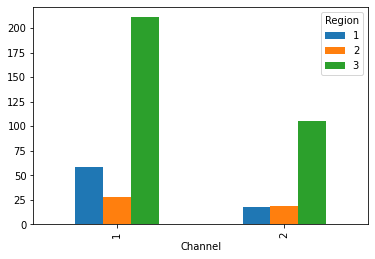

Region    1   2    3
Channel             
1        59  28  211
2        18  19  105


In [353]:
def categorical_multi(i,j):
    pd.crosstab(df[i],df[j]).plot(kind='bar')
    plt.show()
    print(pd.crosstab(df[i],df[j]))

categorical_multi(i='Channel',j='Region') 

### **Visualize numerical Feature**

**1. annotated clustermap**

Text(0.5, 1.0, 'correlations between spending on different categories')

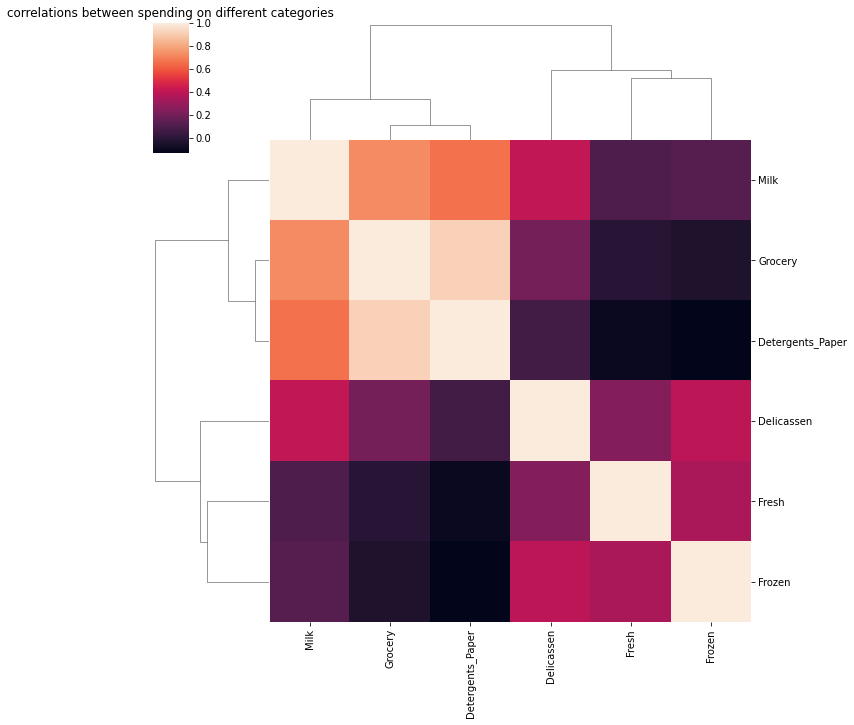

In [354]:
title = 'correlations between spending on different categories'
sns.clustermap(df[num_col].corr(),annot=False)
plt.title(title)

**2. relation plot**

* feature pair with highest correlation : `Detergents_Paper` & `Grocery` <br>
: intuitively makes sense for going "grocery shopping." 
* many points are around 0 : `Delicatessen`
* right-skewed hovering at the origin or near it and long tails : `overall numerical feature`

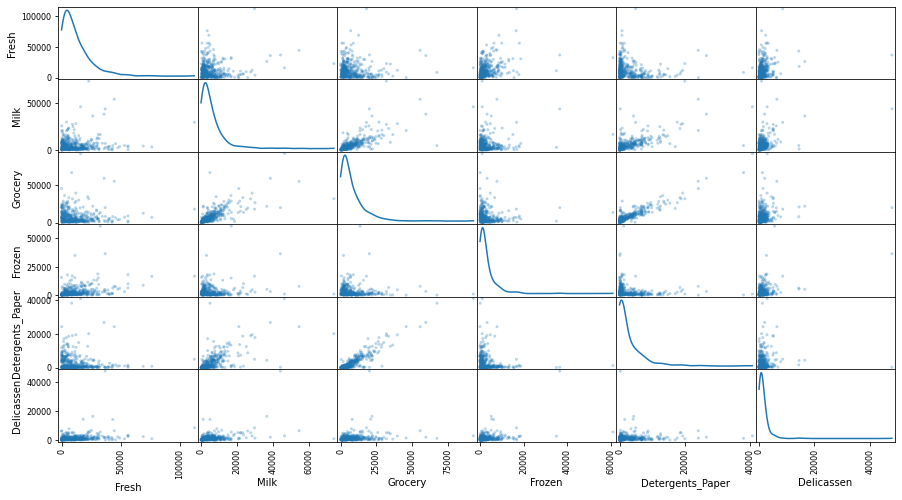

In [355]:
## relation plot for numerical feature
pd.plotting.scatter_matrix(df[num_col], alpha=0.3,figsize=(15,8),diagonal='kde' )
plt.show()

**3. distribution for numeric feature**

* very skewed and "rich" in outliers what can negatively affect

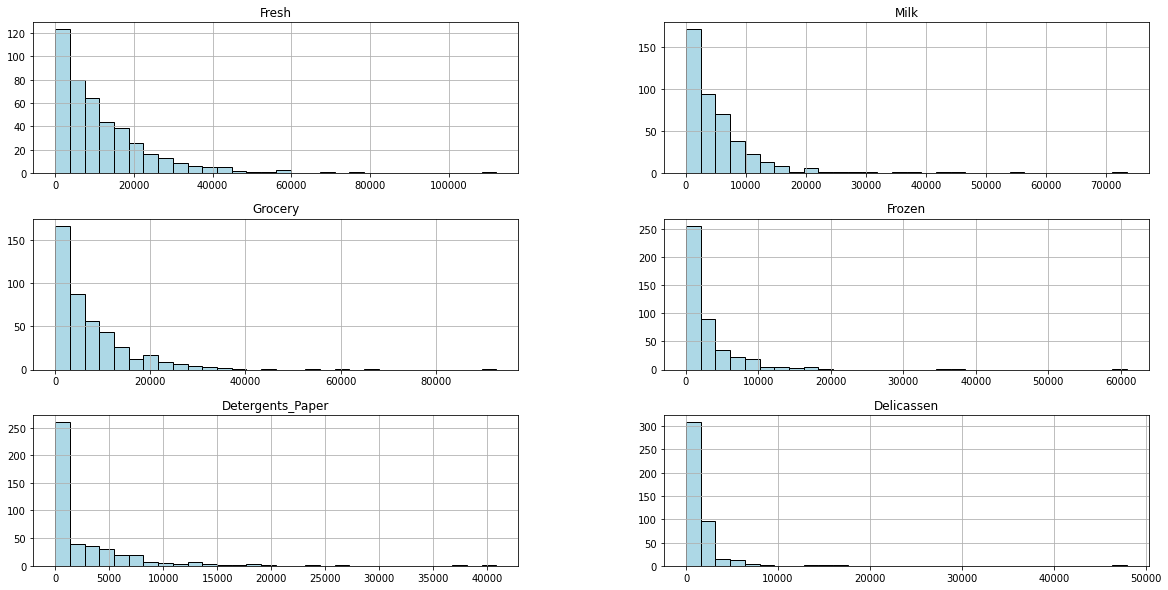

In [356]:
## distribution for numeric feature
df[num_col].hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.show()

## data preprocessing

In [357]:
df_log= df.copy() # 수치형 데이터 : 로그 정규화 
df_log_std = df.copy() # 수치형 범주형 데이터 : 로그 정규화 + 최대최소 정규화
df_cate = df.copy() # 범주형 데이터 : one-hot encoding

### Feature Scaling
* using the natural logarithm

In [358]:
# Scale the data using the natural logarithm
df_log[num_col] = np.log(df_log[num_col])

In [359]:
df_log.drop(cate_col, axis=1, inplace=True)

* 이전보다 정규분포 형태에 가까워짐 관찰 가능

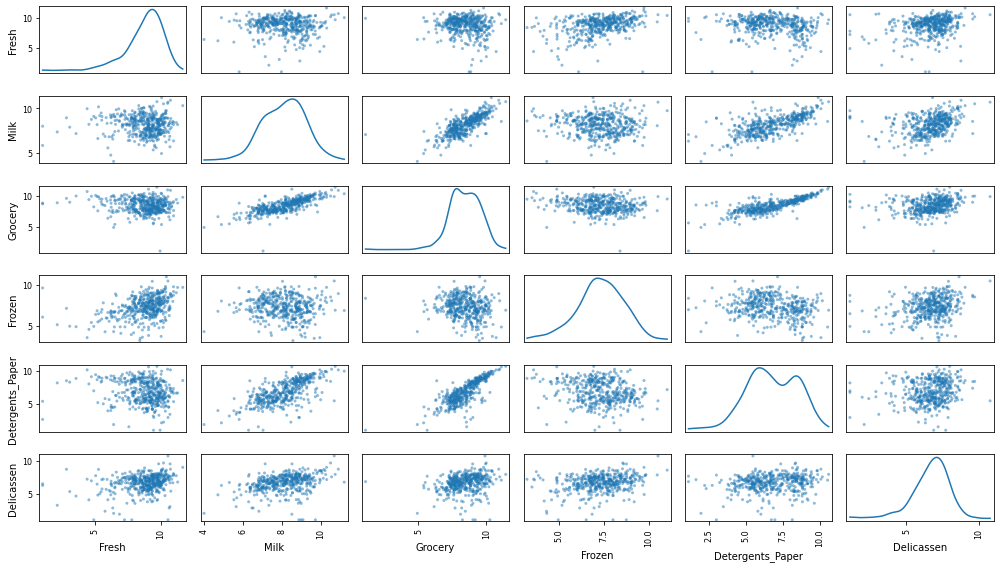

In [360]:
## relationtion Scale numerical feature using the natural logarithm
pd.plotting.scatter_matrix(df_log[num_col], alpha=0.5, figsize=(14,8),diagonal='kde')
plt.tight_layout()

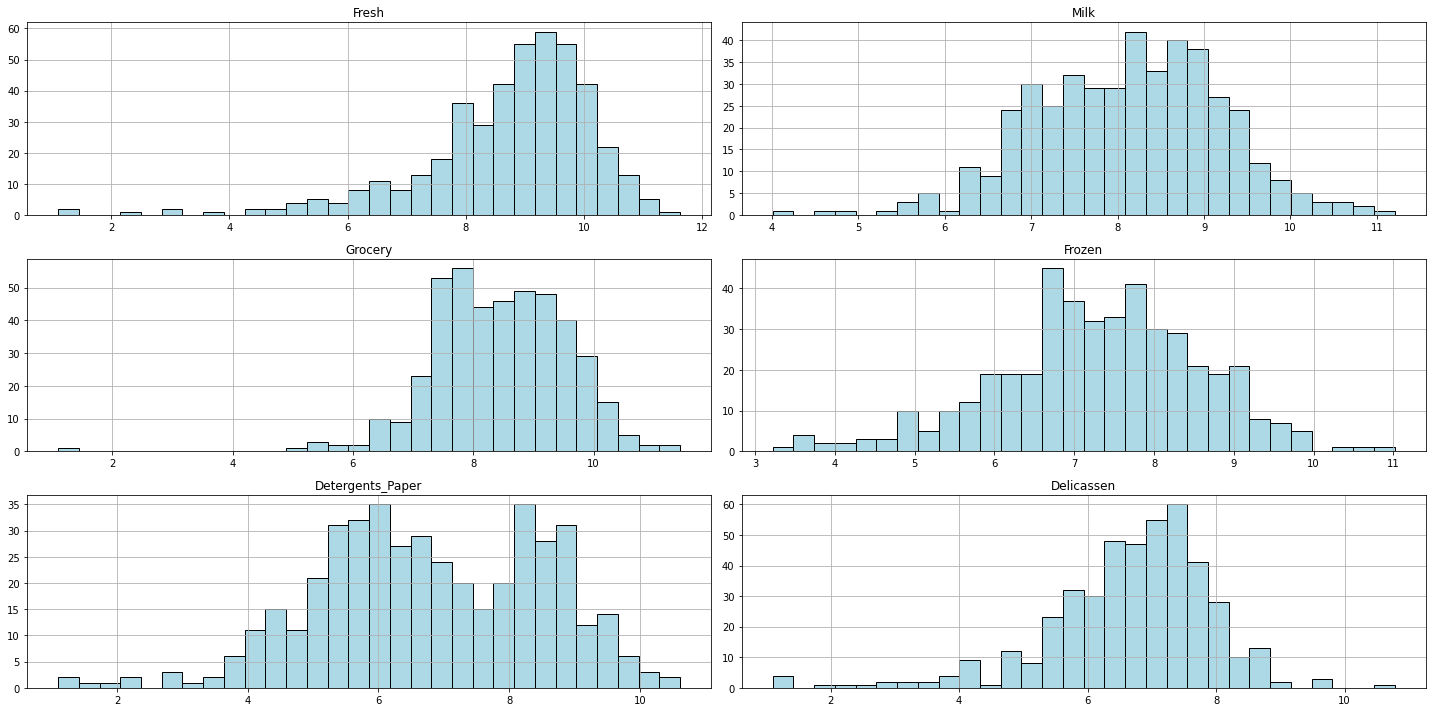

In [361]:
## distribution for Scale numerical feature using the natural logarithm
df_log[num_col].hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.tight_layout()

### MinMaxScaler

*  scale the data to same unit or "distance dimension"

In [362]:
scaler=MinMaxScaler()
columns=df_log[num_col]
norm=scaler.fit_transform(df_log[num_col]) #Only numeric variables
df_log_std[num_col]= norm

In [363]:
df_log_std.drop(cate_col, axis=1, inplace=True)

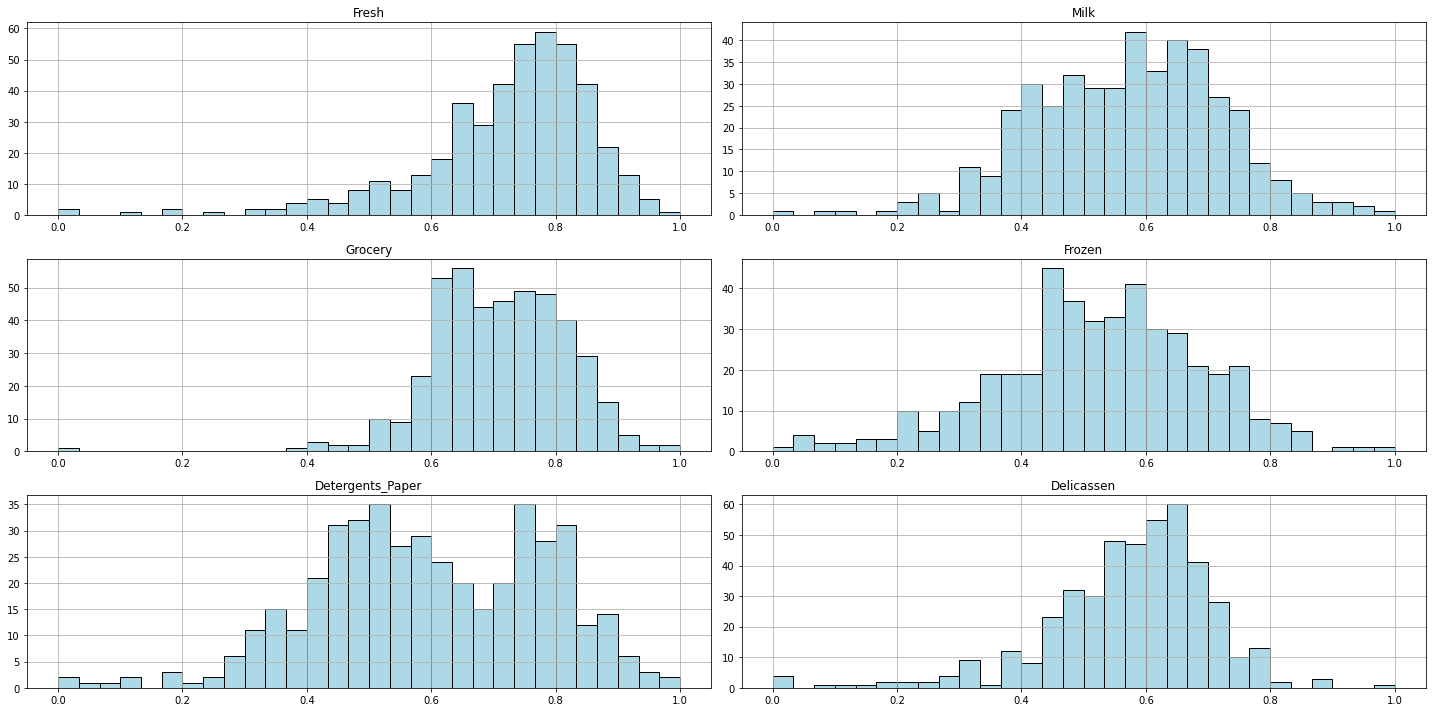

In [364]:
df_log_std[num_col].hist(figsize=(20,10),bins=30, color='lightblue', edgecolor='black')
plt.tight_layout()

### Remove outlier
* individual outliers may have a lot of weight in determing cluste
* move outliers to 1.5 of Interquartile range from 1st or 3rd quartile

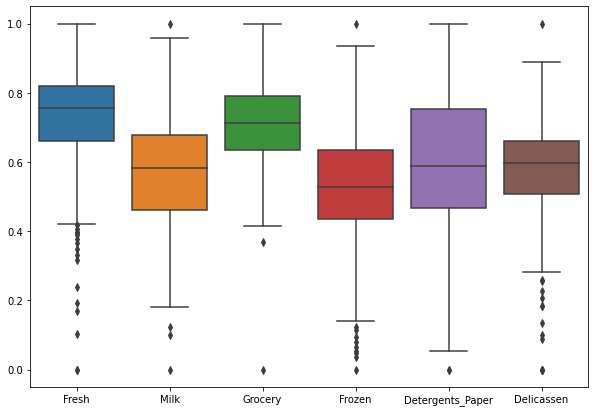

In [365]:
plt.figure(figsize=(10,7))
sns.boxplot(data=df_log_std[num_col])
plt.show()

In [366]:
for i in num_col:
    iqr=np.percentile(df_log_std[i], 75)-np.percentile(df_log_std[i], 25)
    per75=np.percentile(df_log_std[i], 75)
    per25=np.percentile(df_log_std[i], 25)
    df_log_std[i]=np.where(df_log_std[i]>per75+1.5*iqr, per75+1.5*iqr,df_log_std[i] )
    df_log_std[i]=np.where(df_log_std[i]<per25-1.5*iqr, per25-1.5*iqr,df_log_std[i] )

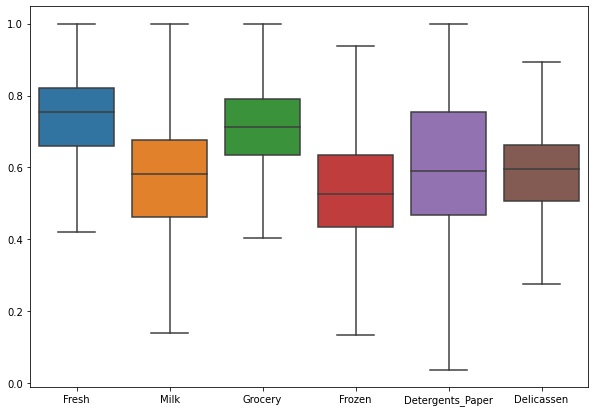

In [367]:

plt.figure(figsize=(10,7))
sns.boxplot(data=df_log_std[num_col])
plt.show()


## data for model
* 수치형 데이터 : scale + outlier 대체값
* 범주형 데이터 : onehot encoding

In [368]:
dummied_category=pd.get_dummies(data=df_cate[cate_col], columns= ['Region','Channel'])
df_cate.drop(cate_col+num_col, axis=1, inplace=True)
df_cate[dummied_category.columns]= dummied_category

In [369]:
data = df.copy()
data.drop(cate_col, axis=1, inplace=True)
data[num_col] = df_log_std 
data[df_cate.columns] = df_cate

In [370]:
data.head() # 여러 모델에 실험적으로 사용할 최종 데이터

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region_1,Region_2,Region_3,Channel_1,Channel_2
0,0.792887,0.718009,0.757507,0.275354,0.713634,0.630253,0,0,1,0,1
1,0.737313,0.720208,0.780276,0.545723,0.735510,0.659511,0,0,1,0,1
2,0.727332,0.705239,0.759068,0.585620,0.742394,0.812973,0,0,1,0,1
3,0.797253,0.427833,0.701127,0.711219,0.538941,0.660206,0,0,1,1,0
4,0.847922,0.637521,0.752748,0.648109,0.670702,0.770203,0,0,1,0,1


## Clustering
1. Hierarchical Clustering (중첩 비허용)
* 거리측정 방식(L1 norm, L2 norm, mahalanobis, corr distance 등)
* 군집과 군집 사이 거리(single, complete, average, centroid, ward)
<br>
2. partitional clustering (중첩 비허용)
* 거리 기반 : KMeans (K + 초기 centroid의 위치 결정 필요)
* 밀도 기반 : DBSCAN (결정해야 하는 것 : eps + minpts)

## Hierarchical Clustering
* 중복 허용해 (=군집 내에 군집 속하기 가능) clustering 하는 방법 
* 일정 높이에서 dendrogram을 잘라서 군집의 수 결정 <br>

방식

* Agglomerative hierarchical clustering : `bottom-up`
* Divisive hierarchical clustering : `top-down`


### **Dendrogram 관찰**

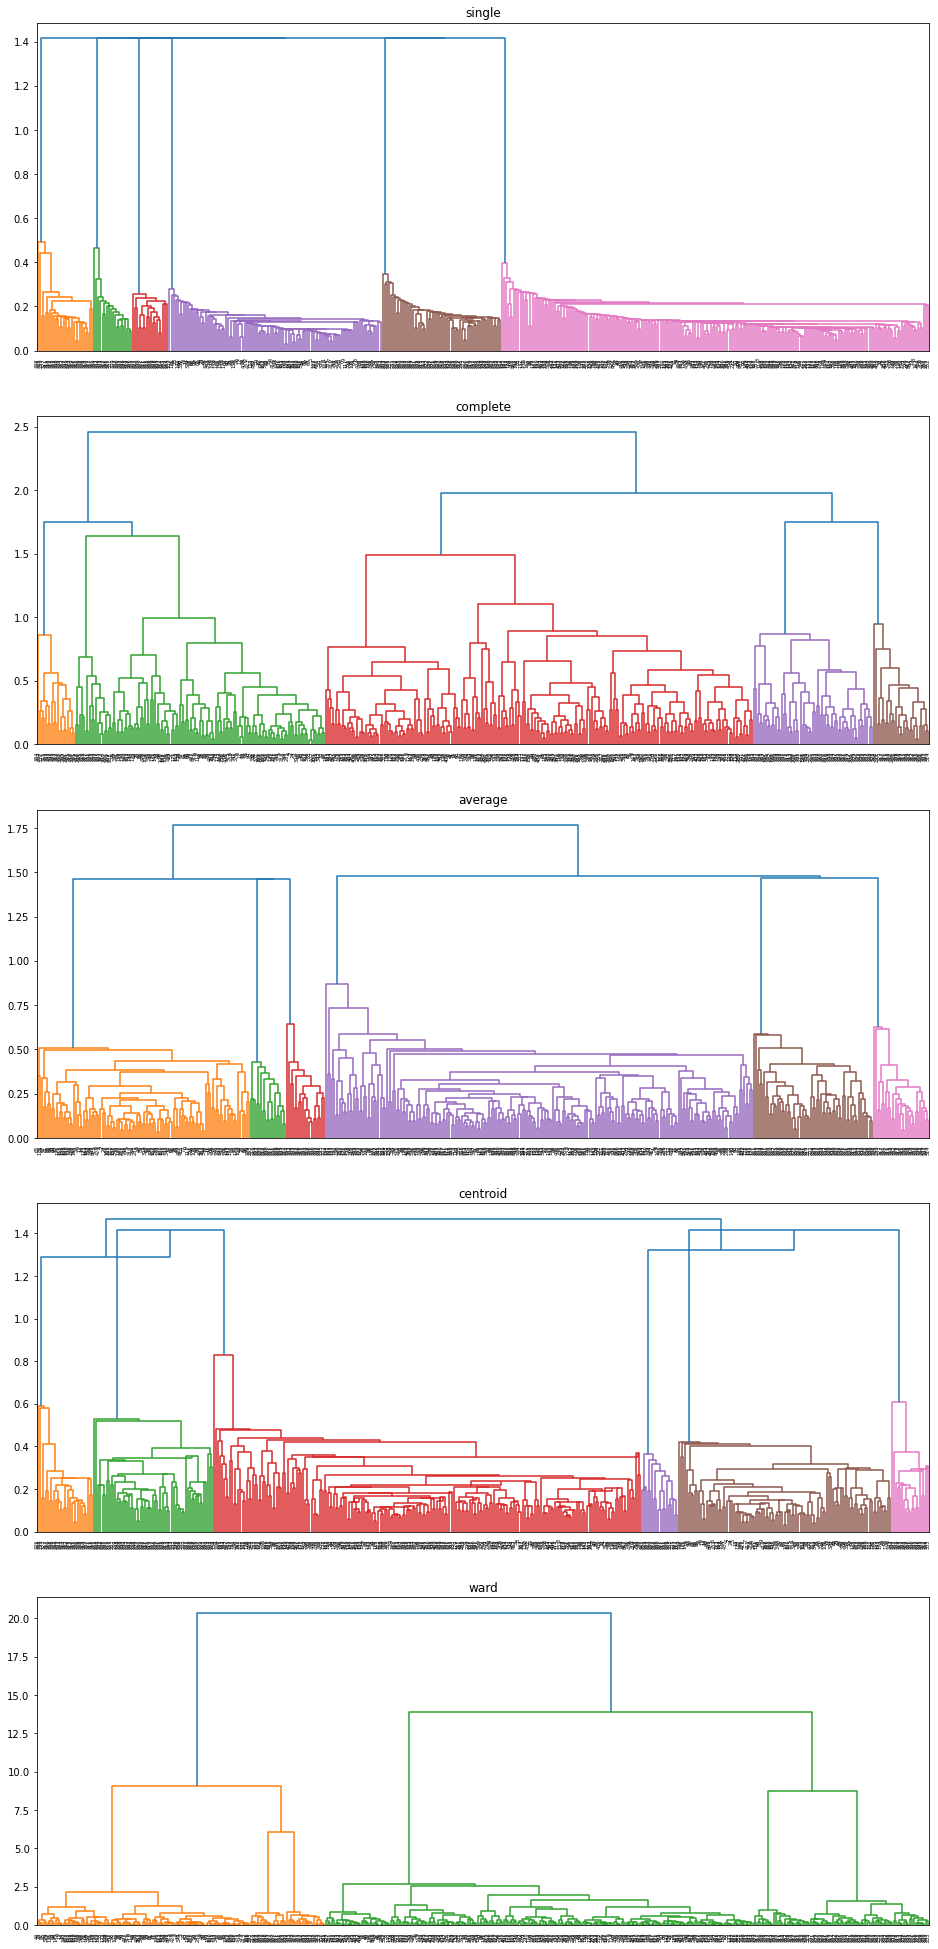

In [371]:
# 순서대로 'single', 'complete', 'average', 'centroid', 'ward' 적용
# 거리 기준 proximity matrix 만들고 cluster 키워가는 방식
# 군집 간 거리 측정 방식 달라짐에 따라 군집화 달라진 결과 발생

linkage_list = ['single', 'complete', 'average', 'centroid', 'ward']

fig, axes = plt.subplots(nrows=len(linkage_list), ncols=1, figsize=(16, 35))

for i in range(len(linkage_list)):
    Z = linkage(data, method=linkage_list[i])
    den = dendrogram(Z, ax=axes[i])
    axes[i].title.set_text(linkage_list[i])
plt.show()


## Select Best K

### **Dendrogram 결과 분석**

* 위 dendrogram 중 ward 방식이 비교적 균일하게 군집화됨
* 직접 cutoff line 그려서 적절한 cluster 갯수 관찰
<br>

**6개의 cluster보다 많아질 경우 cluster 간 거리가 급격하게 줄어듬**<br>
적합한 클러스터 수 : `5개 ~ 6개`

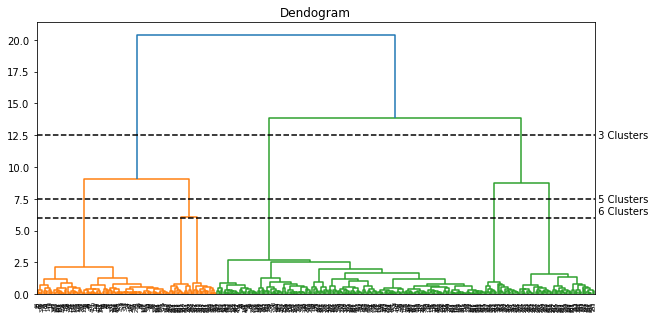

In [372]:
plt.figure(figsize=[10,5])
plt.title('Dendogram')
dendrogram(linkage(data, method="ward"))

# 클러스터를 구분하는 커트라인을 표시
ax = plt.gca()
bounds = ax.get_xbound()
ax.plot(bounds, [7.5, 7.5], '--', c='k')
ax.plot(bounds, [12.5, 12.5], '--', c='k')
ax.plot(bounds, [6, 6], '--', c='k')
ax.text(bounds[1], 6.5, ' 6 Clusters ', va='center', fontdict={'size': 10})
ax.text(bounds[1], 7.5, ' 5 Clusters ', va='center', fontdict={'size': 10})
ax.text(bounds[1], 12.5, ' 3 Clusters ', va='center', fontdict={'size': 10})
plt.show()

## Silhouette Score

### Agglomerative Clustering

In [373]:
### 여러개의 클러스터링 갯수를 List로 입력 받아 각각의 실루엣 계수를 면적으로 시각화한 함수 작성
def visualize_silhouette(clustering, X_features, cluster_lists=[1]): 
    
    n_cols = len(cluster_lists)
    
    # plt.subplots()으로 리스트에 기재된 클러스터링 수만큼의 sub figures를 가지는 axs 생성 
    fig, axs = plt.subplots(figsize=(4*n_cols, 4), nrows=1, ncols=n_cols)
    
    # 리스트에 기재된 클러스터링 갯수들을 차례로 iteration 수행하면서 실루엣 개수 시각화
    for ind, n_cluster in enumerate(cluster_lists):
        
        if clustering[0] == 'hierarchical':
            model = AgglomerativeClustering(n_clusters=n_cluster, linkage=clustering[1])
        cluster_labels = model.fit_predict(X_features)
        
        
        sil_avg = silhouette_score(X_features, cluster_labels)
        sil_values = silhouette_samples(X_features, cluster_labels)
        
        y_lower = 10
        axs[ind].set_title('Number of Cluster : '+ str(n_cluster)+'\n' \
                          'Silhouette Score :' + str(round(sil_avg,3)) )
        axs[ind].set_xlabel("The silhouette coefficient values")
        axs[ind].set_ylabel("Cluster label")
        axs[ind].set_xlim([-0.1, 1])
        axs[ind].set_ylim([-1, len(X_features) + (n_cluster + 1) * 10])
        axs[ind].set_yticks([])  # Clear the yaxis labels / ticks
        axs[ind].set_xticks([0, 0.2, 0.4, 0.6, 0.8, 1])
        
        # 클러스터링 갯수별로 fill_betweenx( )형태의 막대 그래프 표현. 
        for i in range(n_cluster):
            ith_cluster_sil_values = sil_values[cluster_labels==i]
            ith_cluster_sil_values.sort()
            
            size_cluster_i = ith_cluster_sil_values.shape[0]
            y_upper = y_lower + size_cluster_i
            
            color = cm.nipy_spectral(float(i) / n_cluster)
            axs[ind].fill_betweenx(np.arange(y_lower, y_upper), 0, ith_cluster_sil_values, \
                                facecolor=color, edgecolor=color, alpha=0.7)
            axs[ind].text(-0.05, y_lower + 0.5 * size_cluster_i, str(i))
            y_lower = y_upper + 10
            
        axs[ind].axvline(x=sil_avg, color="red", linestyle="--")



### 결과 분석
**`k = 6`일 때**<br> `single`, `complete`, `average`, `ward` 방식 모두 가장 높은 silhouette score 가짐
<br>


In [374]:
params = {
    'linkage':['single', 'complete', 'average', 'ward'],
    'n_clusters':[2, 3, 4, 5, 6, 7, 8, 9, 10]}

scores_hierarcical= {}
for linkage in params['linkage']:
    for n_cluster in params['n_clusters']:
        hierarchical = AgglomerativeClustering(n_clusters=n_cluster, linkage=linkage)
        hierarchical.fit(data)
        score = silhouette_score(data, hierarchical.labels_)
        scores_hierarcical['_'.join(['', linkage, str(n_cluster)])] = score
        
        


pd.Series(scores_hierarcical).sort_values(ascending=False)[:10]

_complete_6    0.734146
_average_6     0.734146
_single_6      0.734146
_ward_6        0.734146
_single_7      0.714340
_single_8      0.701872
_ward_5        0.701496
_average_5     0.701496
_single_9      0.699125
_complete_5    0.681244
dtype: float64

### **주의할 점**
* 한 cluster silhouette 지수가 좋아서 전반적인 silhouette score가 높은 것이라면 그것은 clustering이 잘 되었다고 해석하기에는 무리
*  5개인 경우와 6개인 경우를 모두 시각화해보고 적절해보이는 결과 채택

### **결과 재분석**
* `k=5`와 `k=6` 동시 고려 필요
* k=6일 때와 유사하게 5일 때도 유사하게 높음 
* 5개의 cluster로 분류된 경우 전반적으로 모든 cluster의 실루엣 지수 또한 높음

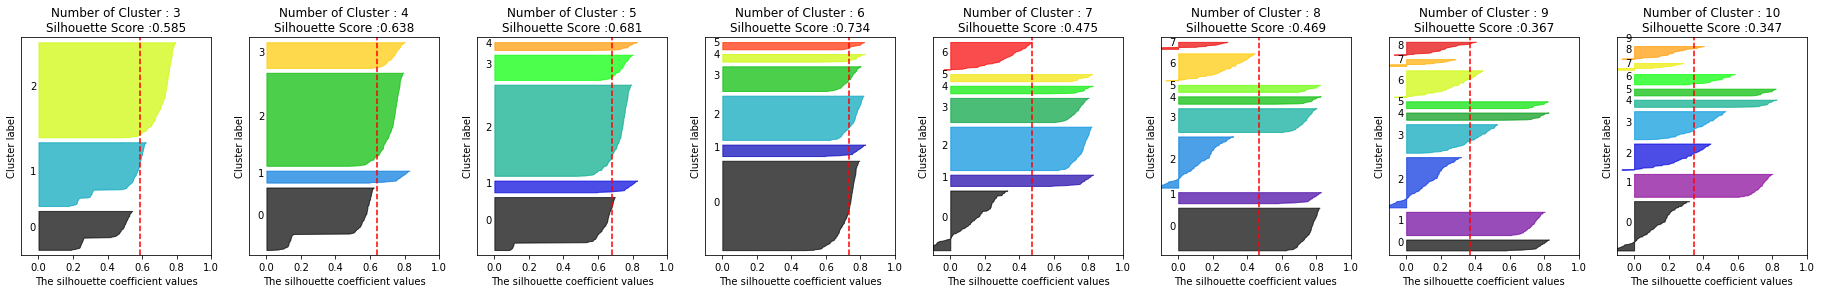

In [375]:
visualize_silhouette(['hierarchical', 'complete'], data, [3,4, 5, 6, 7, 8, 9, 10]) 

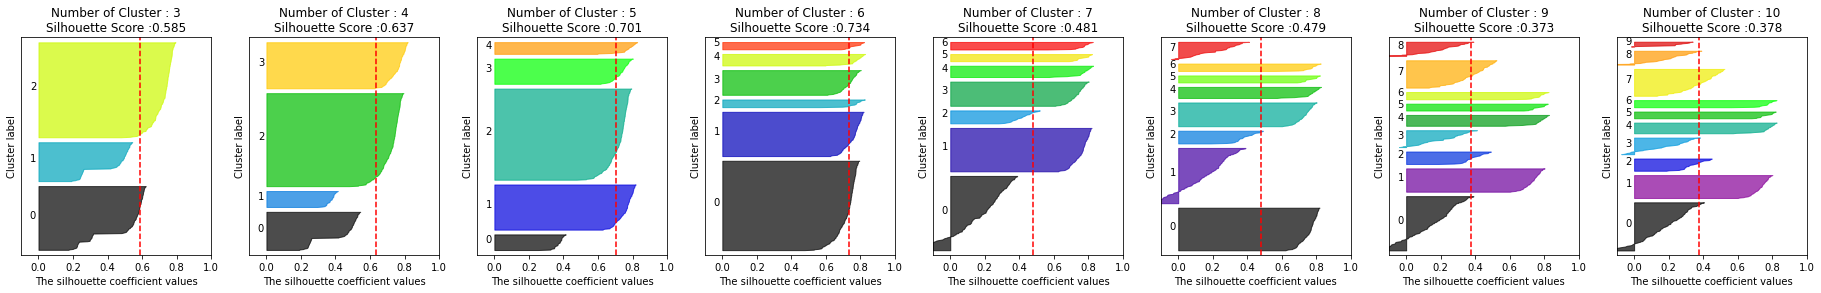

In [376]:
visualize_silhouette(['hierarchical', 'ward'], data, [3, 4, 5, 6, 7, 8, 9, 10]) 

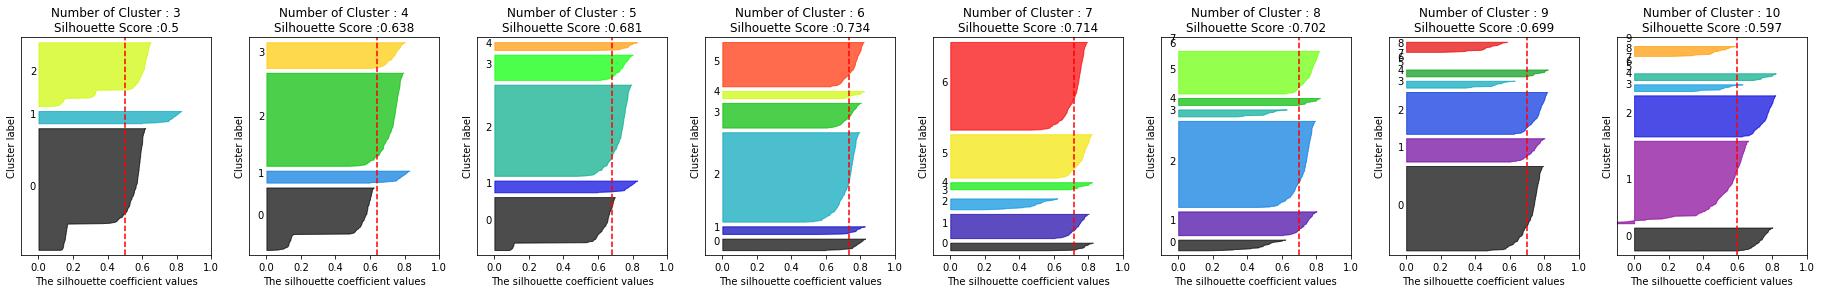

In [377]:
visualize_silhouette(['hierarchical', 'single'], data, [3,4, 5, 6, 7, 8, 9, 10]) 

## PCA

### PCA 도입
* 평면 시각화를 위한 PCA를 이용한 2차원 축소


In [392]:
pca = PCA(n_components=2)
reduced_df = pca.fit_transform(data)
reduced_df.shape

(440, 2)

### 시각화 & 평가
* 차원을 축소해 군집화 진행하고 평가가 한 결과 `k=6` 일 때 가장 적합함

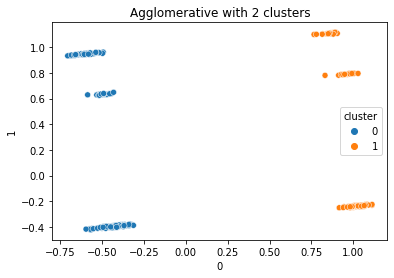

Agglomerative with 2 clusters
Silhouette Coefficient: 0.6796


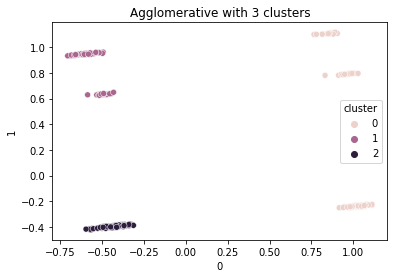

Agglomerative with 3 clusters
Silhouette Coefficient: 0.8415


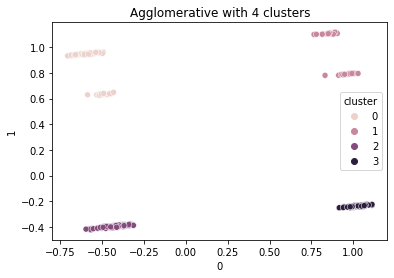

Agglomerative with 4 clusters
Silhouette Coefficient: 0.9284


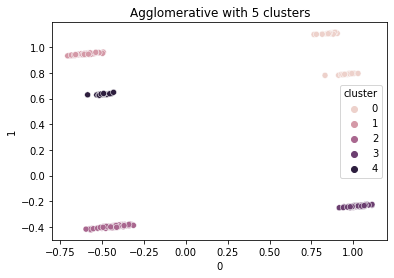

Agglomerative with 5 clusters
Silhouette Coefficient: 0.9244


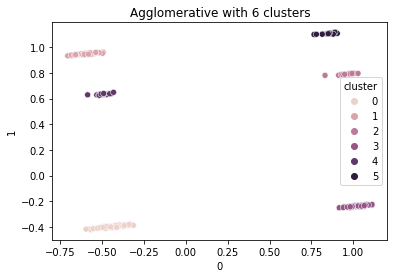

Agglomerative with 6 clusters
Silhouette Coefficient: 0.9264


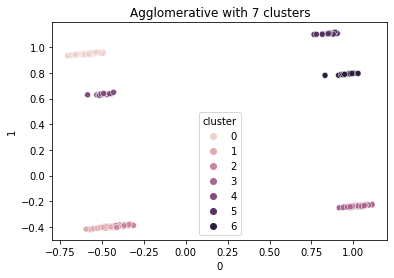

Agglomerative with 7 clusters
Silhouette Coefficient: 0.7398


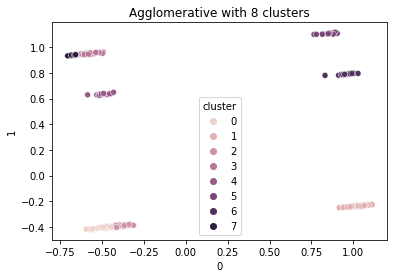

Agglomerative with 8 clusters
Silhouette Coefficient: 0.7026


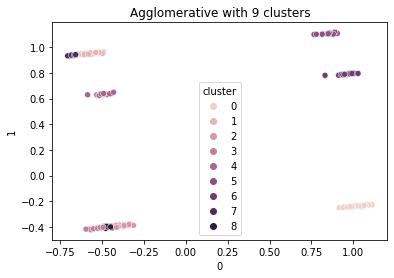

Agglomerative with 9 clusters
Silhouette Coefficient: 0.6965


In [379]:
n = [2,3,4, 5,6, 7, 8, 9]
for i in n:
    agg = AgglomerativeClustering(n_clusters=i)
    cluster = agg.fit(reduced_df)
    cluster_id = pd.DataFrame(cluster.labels_)
    
    d4 = pd.DataFrame()
    d4 = pd.concat([ pd.DataFrame(reduced_df),cluster_id],axis=1)
    d4.columns = [0, 1, "cluster"]
    
    sns.scatterplot(d4[0], d4[1], hue = d4['cluster'], legend="full")
    plt.title('Agglomerative with {} clusters'.format(i))
    plt.show()
    print('Agglomerative with {} clusters'.format(i))
    print('Silhouette Coefficient: {:.4f}'.format(silhouette_score(d4.iloc[:,:-1], d4['cluster'])))
    print("==========================================")

## Overcome black box of clustering

## 군집별 상세 분석

In [397]:
agg = AgglomerativeClustering(n_clusters=6)
cluster = agg.fit(reduced_df)
cluster_id = pd.DataFrame(cluster.labels_)
cluster_id.columns = ["cluster"]

final = pd.DataFrame()
final = pd.concat([ data,cluster_id],axis=1)


In [457]:
df[cate_col]

,Channel,Region
0,2,3
1,2,3
2,2,3
3,1,3
4,2,3
...,...,...
435,1,3
436,1,3
437,2,3
438,1,3


In [455]:
final

,Fresh,Milk,Grocery,Frozen,Detergents_Paper,Delicassen,Region_1,Region_2,Region_3,Channel_1,Channel_2,cluster
0,0.792887,0.718009,0.757507,0.275354,0.713634,0.630253,0,0,1,0,1,3
1,0.737313,0.720208,0.780276,0.545723,0.735510,0.659511,0,0,1,0,1,3
2,0.727332,0.705239,0.759068,0.585620,0.742394,0.812973,0,0,1,0,1,3
3,0.797253,0.427833,0.701127,0.711219,0.538941,0.660206,0,0,1,1,0,0
4,0.847922,0.637521,0.752748,0.648109,0.670702,0.770203,0,0,1,0,1,3
...,...,...,...,...,...,...,...,...,...,...,...,...
435,0.873815,0.748793,0.830168,0.803344,0.431307,0.681817,0,0,1,1,0,0
436,0.900232,0.452756,0.535811,0.666253,0.360770,0.688268,0,0,1,1,0,0
437,0.805911,0.783654,0.891583,0.366915,0.893686,0.664673,0,0,1,0,1,3
438,0.773134,0.497942,0.639501,0.477862,0.422898,0.678046,0,0,1,1,0,0


In [468]:
def region_channel_distribution(cluster):
  res = final[final["cluster"]==cluster].loc[:,["Region_1","Region_2","Region_3","Channel_1","Channel_2"]].sum()
  print(res)

def product_distribution(cluster):
  plt.figure(figsize=(10,7))
  sns.boxplot(data=final[final["cluster"]==cluster].loc[:,["Fresh",	"Milk",	"Grocery",	"Frozen",	"Detergents_Paper"	,"Delicassen"]])
  plt.show()

def feature_importance(cluster):
  x = final.drop(["cluster"],axis=1)

  # Train a classifier

  clf = RandomForestClassifier(random_state=1)

  clf.fit(x.values, dummied_cluster["cluster_"+str(cluster)].values)

  # Index sort the most important features
  sorted_feature_weight_idxes = np.argsort(clf.feature_importances_)[::-1] # Reverse sort

  # Get the most important features names and weights
  most_important_features = np.take_along_axis(
      np.array(dummied_cluster.iloc[:, :-6].columns.tolist()), 
      sorted_feature_weight_idxes, axis=0)
  most_important_weights = np.take_along_axis(
      np.array(clf.feature_importances_), 
      sorted_feature_weight_idxes, axis=0)

  # Show
  list(zip(most_important_features, most_important_weights))
  feature_imp = pd.Series(most_important_weights, index=most_important_features).sort_values(ascending=False)
  plt.figure(figsize=(10,7))

  sns.barplot(x=feature_imp, y=feature_imp.index)
  # Add labels to your graph
  plt.xlabel('Feature Importance Score')
  plt.ylabel('Features')
  plt.title("Visualizing Important Features")
  plt.tight_layout()
    


========================= Cluster 0  ===============================
Region_1       0
Region_2       0
Region_3     211
Channel_1    211
Channel_2      0
dtype: int64


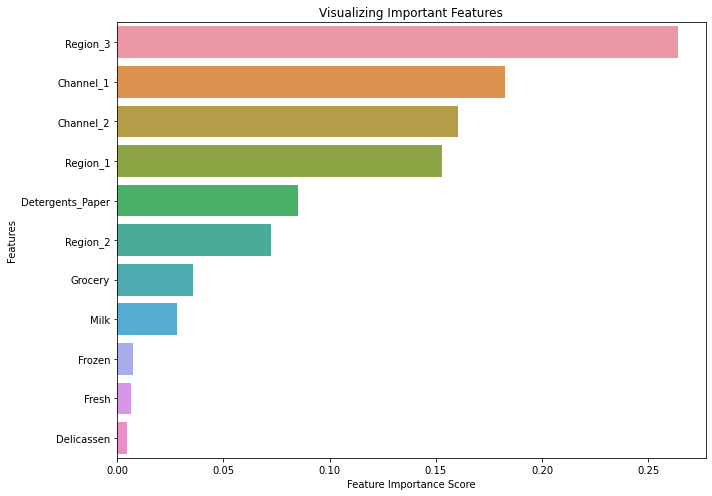

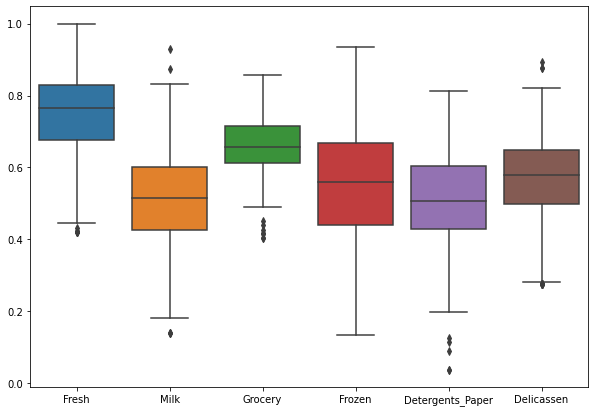



========================= Cluster 1  ===============================
Region_1     59
Region_2      0
Region_3      0
Channel_1    59
Channel_2     0
dtype: int64


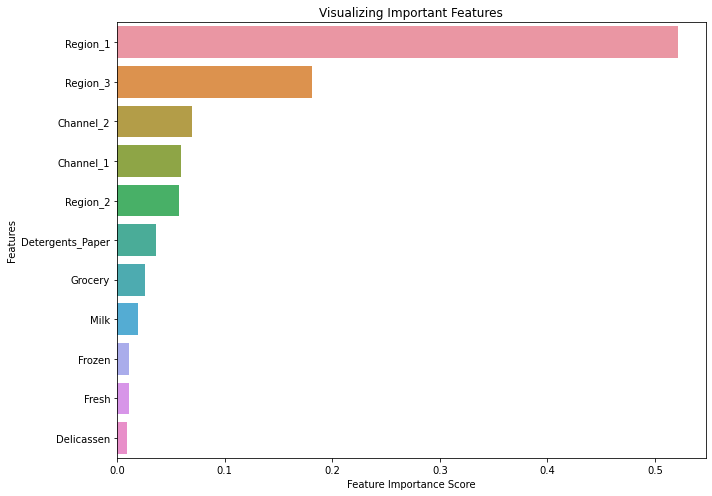

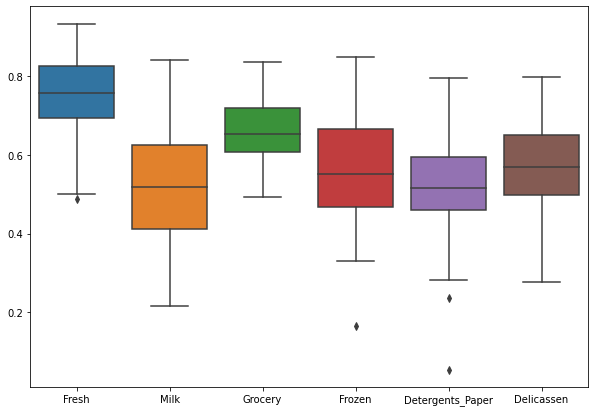



========================= Cluster 2  ===============================
Region_1      0
Region_2     19
Region_3      0
Channel_1     0
Channel_2    19
dtype: int64


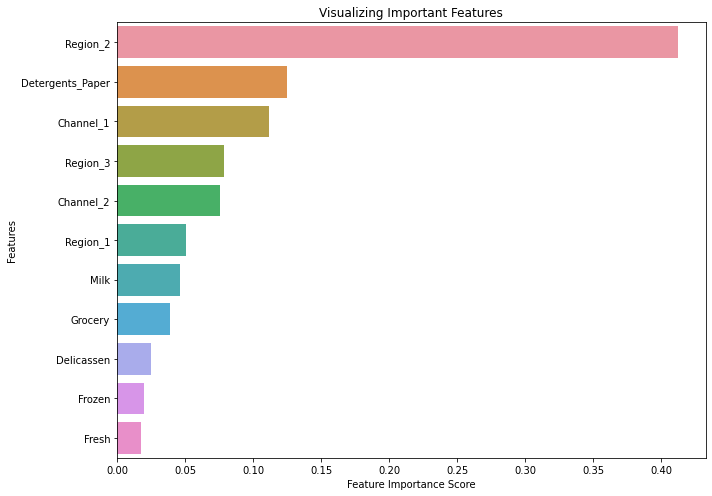

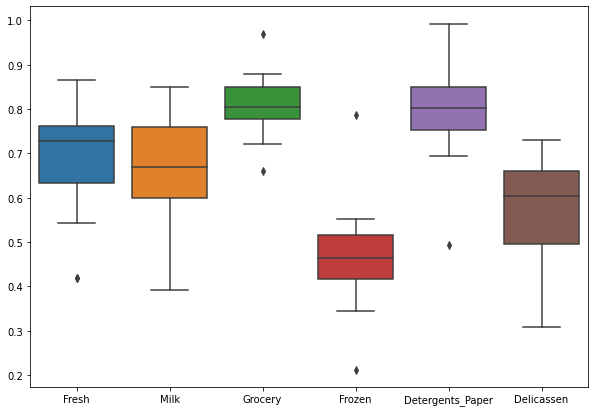



========================= Cluster 3  ===============================
Region_1       0
Region_2       0
Region_3     105
Channel_1      0
Channel_2    105
dtype: int64


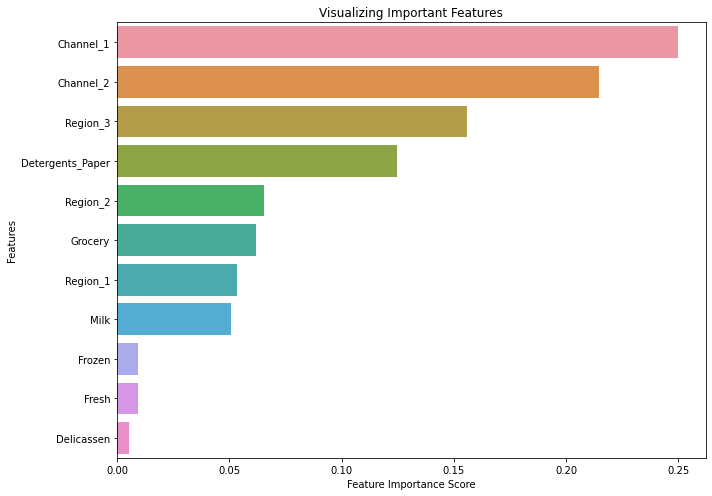

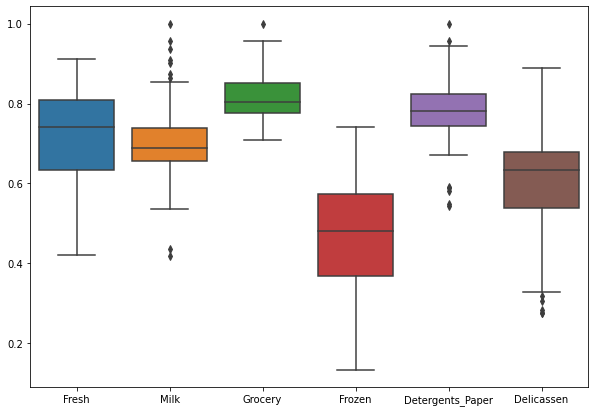



========================= Cluster 4  ===============================
Region_1      0
Region_2     28
Region_3      0
Channel_1    28
Channel_2     0
dtype: int64


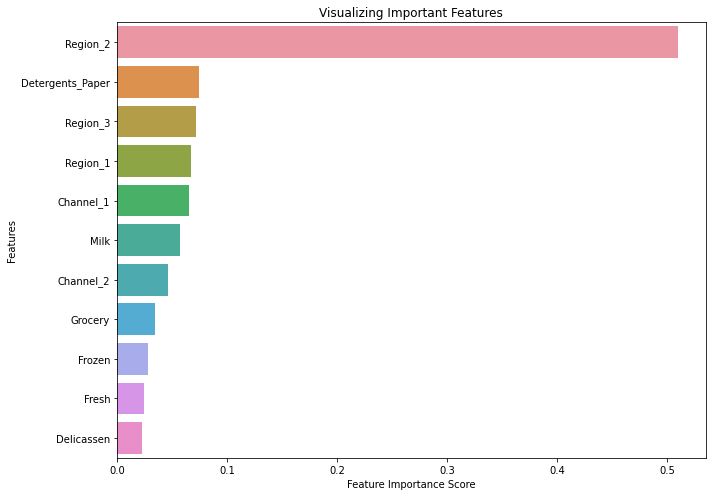

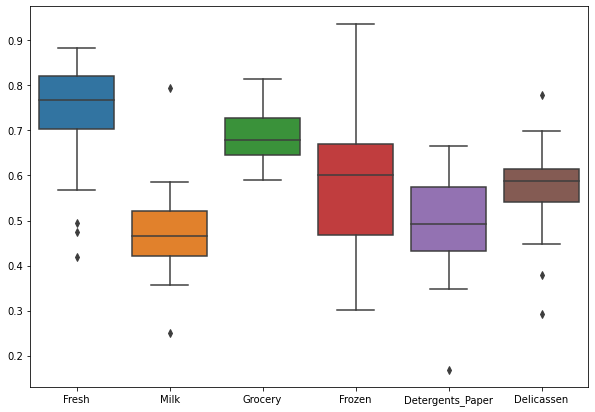



========================= Cluster 5  ===============================
Region_1     18
Region_2      0
Region_3      0
Channel_1     0
Channel_2    18
dtype: int64


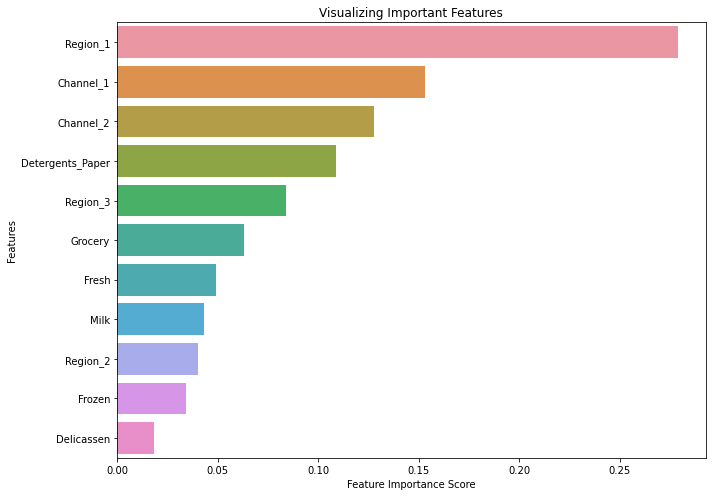

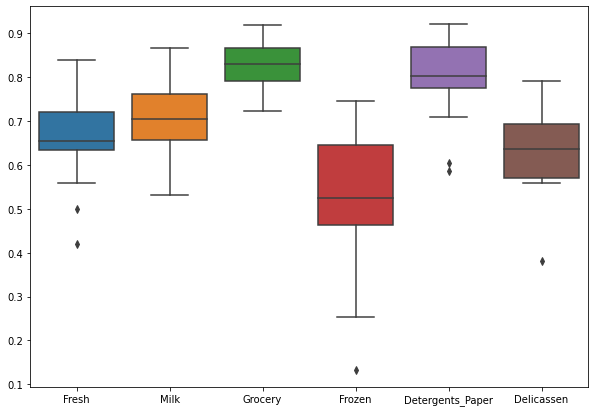

In [492]:
for cluster in sorted(final["cluster"].unique().tolist()):
  print()
  print("========================= Cluster "+str(cluster)+"  ===============================")
  region_channel_distribution(cluster)
  feature_importance(cluster)
  product_distribution(cluster)
  print("==================================================================================")
  print()